<a href="https://colab.research.google.com/github/Chia-Yin-Lee/Text-Analysis/blob/main/Topic_modeling_descrip_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title show your CPU or GPU details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2794109467819116828
 xla_global_id: -1]

In [5]:
#@title connect google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_TA

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_TA


In [6]:
#@title import packages
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from collections import defaultdict
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler

import gensim
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#@title string_to_list function
def string_to_list(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return []

## LDA

In [16]:
#@title game info

df = pd.read_excel('games_info_new.xlsx')
# Drop rows where 'description' is empty or NaN
df = df.dropna(subset=['description'])
df = df[df['description'].str.strip() != '']

In [17]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,ID,name,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,Board Game Rank,owned,wanting,wishing,new_description
0,30549,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...",106,168364,625,9344,"['pandem', 'virul', 'diseas', 'broken', 'simul..."
1,822,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,30,45,7,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...",191,161299,582,7383,"['carcassonn', 'tile', 'placement', 'game', 'p..."
2,13,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,60,120,10,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...",429,167733,485,5890,"['catan', 'settler', 'catan', 'player', 'try',..."
3,68448,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...",73,120466,1010,12105,"['leader', 'great', 'citi', 'ancient', 'world'..."
4,36218,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,13,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...",104,106956,655,8621,"['monarch', 'like', 'parent', 'ruler', 'small'..."


In [18]:
df['boardgamemechanic'] = df['boardgamemechanic'].apply(string_to_list)
df['boardgamecategory'] = df['boardgamecategory'].apply(string_to_list)
df['new_description'] = df['new_description'].apply(string_to_list)

def combine_columns(row):
    combined_list = []
    combined_list.extend([word.lower() for word in row['boardgamemechanic']])
    combined_list.extend([word.lower() for word in row['boardgamecategory']])
    combined_list.extend([word.lower() for word in row['new_description']])
    return combined_list

df['combined_final'] = df.apply(combine_columns, axis=1)

df.head()

,ID,name,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,Board Game Rank,owned,wanting,wishing,new_description,combined_final
0,30549,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,[Medical],"[Action Points, Cooperative Game, Hand Managem...",106,168364,625,9344,"[pandem, virul, diseas, broken, simultan, worl...","[action points, cooperative game, hand managem..."
1,822,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,30,45,7,"[City Building, Medieval, Territory Building]","[Area Majority / Influence, Map Addition, Tile...",191,161299,582,7383,"[carcassonn, tile, placement, game, player, dr...","[area majority / influence, map addition, tile..."
2,13,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,60,120,10,"[Economic, Negotiation]","[Dice Rolling, Hexagon Grid, Income, Modular B...",429,167733,485,5890,"[catan, settler, catan, player, try, domin, fo...","[dice rolling, hexagon grid, income, modular b..."
3,68448,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,10,"[Ancient, Card Game, City Building, Civilizati...","[Drafting, Hand Management, Set Collection, Si...",73,120466,1010,12105,"[leader, great, citi, ancient, world, gather, ...","[drafting, hand management, set collection, si..."
4,36218,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,13,"[Card Game, Medieval]","[Deck, Bag, and Pool Building, Delayed Purchas...",104,106956,655,8621,"[monarch, like, parent, ruler, small, pleasant...","[deck, bag, and pool building, delayed purchas..."


In [19]:
# Define the words to exclude
exclude_words = ['player', 'game', 'win']

# Preprocess the text to remove excluded words
df['text'] = df['combined_final'].apply(lambda words: [word for word in words if word not in exclude_words])

dictionary = corpora.Dictionary(df['text'])

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in df['text']]

In [ ]:
#@title Find the best number of topics

topic_range = range(3, 11)
coherence_scores = []

# Calculate coherence scores for different numbers of topics
for num_topics in topic_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=df['text'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


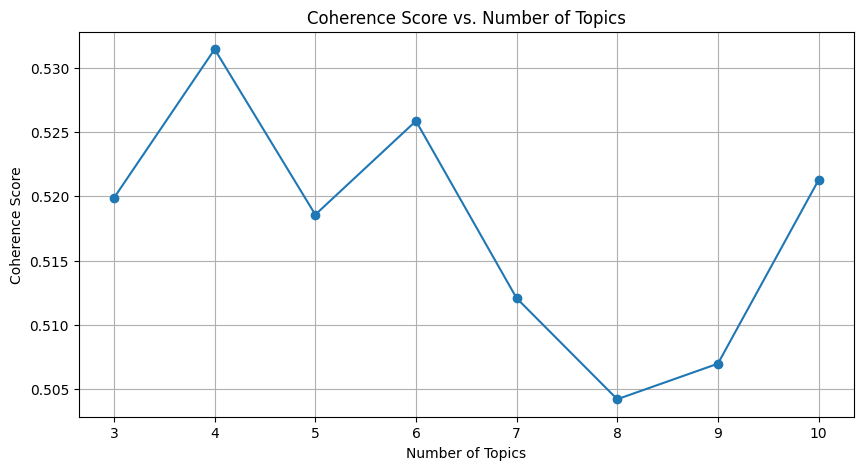

In [ ]:
#@title Plot the coherence scores to visualize the results

plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_range)
plt.grid(True)
plt.savefig('coherence_scores_game_lv.png')

plt.show()

The optimal number of topics is typically the one that corresponds to the highest coherence score on the plot.
I choose 6, 10 to see the words in each topic.

In [ ]:
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15, random_state=42)

# Print topics and their top words
for topic_id, topic in lda_model.print_topics():
    print(f'Topic {topic_id + 1}: {topic}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: 0.042*"anim" + 0.019*"question" + 0.015*"trivia" + 0.015*"que" + 0.013*"categori" + 0.013*"ingredi" + 0.012*"answer" + 0.012*"food" + 0.011*"movi" + 0.011*"lo"
Topic 2: 0.037*"tile" + 0.032*"board" + 0.027*"place" + 0.024*"piec" + 0.020*"turn" + 0.020*"point" + 0.017*"space" + 0.017*"color" + 0.016*"score" + 0.016*"number"
Topic 3: 0.152*"card" + 0.038*"plai" + 0.024*"point" + 0.018*"hand" + 0.017*"turn" + 0.017*"round" + 0.016*"card game" + 0.014*"deck" + 0.013*"score" + 0.013*"number"
Topic 4: 0.030*"team" + 0.014*"guess" + 0.012*"answer" + 0.012*"party game" + 0.012*"deduction" + 0.011*"question" + 0.009*"clue" + 0.009*"parti" + 0.009*"word" + 0.008*"stori"
Topic 5: 0.012*"race" + 0.011*"plai" + 0.010*"children's game" + 0.009*"board" + 0.007*"time" + 0.007*"publish" + 0.007*"fun" + 0.006*"action / dexterity" + 0.006*"like" + 0.006*"try"
Topic 6: 0.101*"dice" + 0.058*"roll" + 0.023*"dice rolling" + 0.023*"treasur" + 0.021*"die" + 0.014*"pirat" + 0.012*"island" + 0.012*"ship

* Topic 1: puzzle game
* Topic 2: board game
* Topic 3: card game
* Topic 4: team party game
* Topic 5: children's action game
* Topic 6: dice rolling -> treasure
* Topic 7: war game
* Topic 8: bulid city
* Topic 9: sci-fi
* Topic 10: card -> fantasy battle

In [ ]:
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=15, random_state=42)

# Print topics and their top words
for topic_id, topic in lda_model.print_topics():
    print(f'Topic {topic_id + 1}: {topic}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: 0.013*"war" + 0.013*"battl" + 0.013*"unit" + 0.011*"rule" + 0.010*"wargame" + 0.009*"map" + 0.009*"armi" + 0.008*"plai" + 0.007*"turn" + 0.007*"counter"
Topic 2: 0.016*"build" + 0.010*"point" + 0.009*"citi" + 0.008*"end" + 0.008*"action" + 0.007*"new" + 0.007*"resourc" + 0.007*"place" + 0.006*"turn" + 0.006*"tile"
Topic 3: 0.072*"card" + 0.024*"plai" + 0.016*"point" + 0.013*"turn" + 0.011*"number" + 0.010*"place" + 0.010*"score" + 0.010*"dice" + 0.010*"board" + 0.009*"round"
Topic 4: 0.016*"team" + 0.009*"race" + 0.008*"time" + 0.006*"ball" + 0.005*"deduction" + 0.005*"clue" + 0.005*"car" + 0.005*"try" + 0.004*"question" + 0.004*"publish"
Topic 5: 0.016*"card" + 0.012*"plai" + 0.010*"charact" + 0.009*"power" + 0.007*"hero" + 0.007*"fantasy" + 0.006*"deck" + 0.006*"new" + 0.006*"monster" + 0.006*"attack"
Topic 6: 0.026*"ship" + 0.013*"treasur" + 0.011*"space" + 0.010*"planet" + 0.009*"pirat" + 0.008*"mission" + 0.008*"crew" + 0.007*"zombi" + 0.007*"island" + 0.007*"science fict

* Topic 1: war game
* Topic 2: build city
* Topic 3: card & dice
* Topic 4: team & race (car/ ball)
* Topic 5: fantasy w/ character (hero/monter)
* Topic 6: sci & treasure

After checking results of num_topics = 6 and 10, we choose 10 to move forward.

In [20]:
#@title Do optimal LDA model & Put the resulted topics into a new column in the DataFrame

# Get the optimal LDA model
num_topic_chosen = 10
optimal_lda_model = LdaModel(corpus, num_topics=num_topic_chosen, id2word=dictionary, passes=15, random_state=42)

# get_document_topics: to assign a list of topics and their probabilities to each game based on the trained LDA model
df['topic_assignment'] = df['text'].apply(lambda text: optimal_lda_model.get_document_topics(dictionary.doc2bow(text)))
# Keep only the most likely topic for each game
df['main_topic'] = df['topic_assignment'].apply(lambda topics: max(topics, key=lambda x: x[1]))

In [21]:
if type(df['main_topic'][0]) is str:
  df['main_topic_idx'] = df['main_topic'].apply(lambda topics: topics[1])
else:
  df['main_topic_idx'] = df['main_topic'].apply(lambda topics: topics[0])  # main_topic_idx = 0, 1, ..., 9

df.head()

,ID,name,description,yearpublished,minplayers,maxplayers,minplaytime,maxplaytime,minage,boardgamecategory,...,Board Game Rank,owned,wanting,wishing,new_description,combined_final,text,topic_assignment,main_topic,main_topic_idx
0,30549,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,8,[Medical],...,106,168364,625,9344,"[pandem, virul, diseas, broken, simultan, worl...","[action points, cooperative game, hand managem...","[action points, cooperative game, hand managem...","[(2, 0.14771378), (4, 0.033338133), (7, 0.5616...","(7, 0.56160724)",7
1,822,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,30,45,7,"[City Building, Medieval, Territory Building]",...,191,161299,582,7383,"[carcassonn, tile, placement, game, player, dr...","[area majority / influence, map addition, tile...","[area majority / influence, map addition, tile...","[(1, 0.70025694), (6, 0.026403593), (7, 0.2656...","(1, 0.70025694)",1
2,13,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,60,120,10,"[Economic, Negotiation]",...,429,167733,485,5890,"[catan, settler, catan, player, try, domin, fo...","[dice rolling, hexagon grid, income, modular b...","[dice rolling, hexagon grid, income, modular b...","[(0, 0.010050794), (1, 0.19518247), (2, 0.1045...","(7, 0.4958845)",7
3,68448,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,10,"[Ancient, Card Game, City Building, Civilizati...",...,73,120466,1010,12105,"[leader, great, citi, ancient, world, gather, ...","[drafting, hand management, set collection, si...","[drafting, hand management, set collection, si...","[(2, 0.40257612), (7, 0.5550225), (9, 0.036925...","(7, 0.5550225)",7
4,36218,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,13,"[Card Game, Medieval]",...,104,106956,655,8621,"[monarch, like, parent, ruler, small, pleasant...","[deck, bag, and pool building, delayed purchas...","[deck, bag, and pool building, delayed purchas...","[(2, 0.21980596), (4, 0.13529012), (5, 0.03316...","(7, 0.30197)",7


In [ ]:
# Print topics and their top words
for topic_id, topic in optimal_lda_model.print_topics():
    print(f'Topic {topic_id + 1}: {topic}')

Topic 1: 0.042*"anim" + 0.019*"question" + 0.015*"trivia" + 0.015*"que" + 0.013*"categori" + 0.013*"ingredi" + 0.012*"answer" + 0.012*"food" + 0.011*"movi" + 0.011*"lo"
Topic 2: 0.037*"tile" + 0.032*"board" + 0.027*"place" + 0.024*"piec" + 0.020*"turn" + 0.020*"point" + 0.017*"space" + 0.017*"color" + 0.016*"score" + 0.016*"number"
Topic 3: 0.152*"card" + 0.038*"plai" + 0.024*"point" + 0.018*"hand" + 0.017*"turn" + 0.017*"round" + 0.016*"card game" + 0.014*"deck" + 0.013*"score" + 0.013*"number"
Topic 4: 0.030*"team" + 0.014*"guess" + 0.012*"answer" + 0.012*"party game" + 0.012*"deduction" + 0.011*"question" + 0.009*"clue" + 0.009*"parti" + 0.009*"word" + 0.008*"stori"
Topic 5: 0.012*"race" + 0.011*"plai" + 0.010*"children's game" + 0.009*"board" + 0.007*"time" + 0.007*"publish" + 0.007*"fun" + 0.006*"action / dexterity" + 0.006*"like" + 0.006*"try"
Topic 6: 0.101*"dice" + 0.058*"roll" + 0.023*"dice rolling" + 0.023*"treasur" + 0.021*"die" + 0.014*"pirat" + 0.012*"island" + 0.012*"ship

9    4277
2    3576
6    3378
7    3336
4    2352
1    1852
3    1079
8     985
5     504
0     291
Name: main_topic_idx, dtype: int64


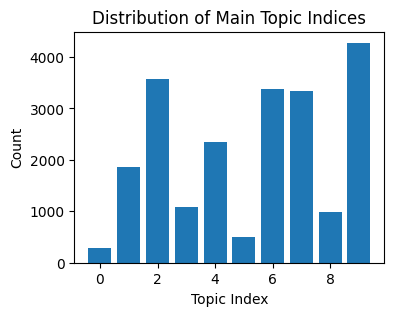

In [31]:
value_counts = df['main_topic_idx'].value_counts()
print(value_counts)

# Create a bar plot
plt.figure(figsize=(4, 3))
plt.bar(value_counts.index, value_counts.values)

plt.xlabel('Topic Index')
plt.ylabel('Count')
plt.title('Distribution of Main Topic Indices')

plt.show()

In [22]:
#@title Save the DataFrame with LDA results & the LDA model

df.to_csv('Description_topic.csv', index=False)

with open('lda_model.pkl', 'wb') as file:
    pickle.dump(optimal_lda_model, file)


## User New Input

In [37]:
#@title Load models from previous sentiment analysis

with open('LogicticRegression_3.pickle', 'rb') as model_file_LR:
    loaded_model_LR = pickle.load(model_file_LR)

with open('MultinomialNB_3.pickle', 'rb') as model_file_MNB:
    loaded_model_MNB = pickle.load(model_file_MNB)

with open('SVC_3.pickle', 'rb') as model_file_SVC:
    loaded_model_SVC = pickle.load(model_file_SVC)

In [38]:
#@title New Input Text Preprocessing

def preprocess_text(text):

    text = text.lower()
    tokens = word_tokenize(text)

    # Removing punctuation and stop words
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    return ' '.join(tokens)

tfidf_vectorizer = pickle.load(open("Tfidvectorizer.pkl", 'rb'))

# Create new tfidfVectorizer with old vocabulary
tfidf_vectorizer_new = TfidfVectorizer(analyzer='word', stop_words = "english", vocabulary = tfidf_vectorizer.vocabulary_)

In [39]:
#@title preprocess_text on User's Input

user_request_1 = 'I want a good war game'  # positive
user_request_0 = 'I hate chess'  # negative
num_topic_chosen = 10

# Checking!
print(preprocess_text(user_request_1))
print(preprocess_text(user_request_0))

want good war game
hate chess


In [40]:
#@title Prediction_balanced function: Simple majority on the 3 models

def Prediction_balanced(text, vectorizer = tfidf_vectorizer_new):
  new_input = vectorizer.fit_transform([preprocess_text(text)])

  # Make predictions
  predictions_SVC = loaded_model_SVC.predict(new_input)
  predictions_LR = loaded_model_LR.predict(new_input)
  predictions_MNB = loaded_model_MNB.predict(new_input)

  #print('SVC', predictions_SVC)
  #print('Logistic Regression', predictions_LR)
  #print('M Naive Bayes', predictions_MNB)

  pred_list = [int(predictions_SVC[0]), int(predictions_LR[0]), int(predictions_MNB[0])]
  most_common_element = max(pred_list, key=lambda x: pred_list.count(x))
  return most_common_element

# Checking!
print('"', user_request_1, '" has a rating of', Prediction_balanced(user_request_1))
print('"', user_request_0, '" has a rating of', Prediction_balanced(user_request_0))

" I want a good war game " has a rating of 1
" I hate chess " has a rating of 0


**Remind:**

* Topic 1: puzzle game (food)
* Topic 2: board game
* Topic 3: card game
* Topic 4: team party game
* Topic 5: children's action game
* Topic 6: dice rolling -> treasure
* Topic 7: war game
* Topic 8: bulid city
* Topic 9: sci-fi
* Topic 10: card -> fantasy battle

In [41]:
#@title Load the LDA model and DataFrame from the saved file

df = pd.read_csv('Description_topic.csv')

with open('lda_model.pkl', 'rb') as file:
    loaded_lda_model = pickle.load(file)

In [42]:
#@title LDA_on_new_input function
# Return the topic the new input is assigned to & a vector of probability

def LDA_on_new_input(input_text, df):
  exclude_words = ['player', 'game', 'win']

  input_tokens = input_text.split()  # Tokenize and preprocess as needed
  new_input_tokens = [word for word in input_tokens if word not in exclude_words]

  if type(df['text'][0]) == str:
    df['text'] = df['text'].apply(string_to_list)

  dictionary = corpora.Dictionary(df['text'])

  new_input_bow = dictionary.doc2bow(new_input_tokens)
  new_input_topics = loaded_lda_model.get_document_topics(new_input_bow)  # Topic 1 ~ 10 (topic idx 0 ~ 9)

  sorted_new_input_topics = sorted(new_input_topics, key=lambda x: -x[1])  # Prob high -> low

  run = 0
  for topic, prob in sorted_new_input_topics:
      if run == 0:
        new_input_topic_index = topic  # topic the new input is assigned to
      run += 1

  # Extract the second elements from the tuples
  resulted_prob = [item[1] for item in new_input_topics]

  # Create a NumPy array from the extracted values
  matrix_prob = np.array(resulted_prob)
  matrix_prob = matrix_prob.reshape(-1, 1)

  return new_input_topic_index, matrix_prob

In [43]:
#@title cate_in_topic function

def cate_in_topic(df, num_topic):
  topic_cate_num = defaultdict(dict)
  for i in range(num_topic):
    cate_num = defaultdict(int)
    filtered_df = df['boardgamecategory'][df['main_topic_idx'] == i]
    big_list = filtered_df.apply(pd.Series, dtype=object).stack().tolist()

    for cate in big_list:
      cate_num[cate] += 1

    topic_cate_num[i+1] = cate_num

  return topic_cate_num

In [44]:
#@title dict_to_matrix_and_df function

def dict_to_matrix(topic_cate_num_dict):

  # Extract row (topic) and column (category) names
  row_names = list(topic_cate_num_dict.keys())
  column_names = list(next(iter(topic_cate_num_dict.values())).keys())

  # Extract values
  matrix_values = [[topic_cate_num_dict[row][col] for col in column_names] for row in row_names]

  # Create a NumPy array from the values
  matrix = np.array(matrix_values)

  # Convert the nested dictionary to a DataFrame
  topic_cate_num_df = pd.DataFrame.from_dict(topic_cate_num_dict, orient='index')

  # Set row names as the index
  topic_cate_num_df.index.name = 'Topic'

  # Fill NaN values with 0
  topic_cate_num_df = topic_cate_num_df.fillna(0)
  topic_cate_num_df = topic_cate_num_df.astype(int)

  return matrix, topic_cate_num_df

# topic_cate_num_df.to_csv('topic_cate_num_df.csv', index=True)

In [45]:
#@title normalize_matrix function

def normalize_matrix(matrix, matrix_prob):
  normalized_matrix = matrix / matrix.sum(axis=1, keepdims=True)

  #print(sum(normalized_matrix[0]))  # Check sum = 1!

  element_wise_product = normalized_matrix * matrix_prob
  matrix_result = np.sum(element_wise_product, axis=0)

  return matrix_result

In [46]:
#@title topic_name_assigned function

def topic_name_assigned(topic_cate_num_df, matrix_result):
  dict_result = {}
  for index, element in enumerate(matrix_result):
      dict_result[topic_cate_num_df.columns[index]] = element

  # Find the key with the largest value
  cate_of_largest_value = max(dict_result, key=dict_result.get)

  return cate_of_largest_value  # 'Party Game'

In [47]:
#@title game_selection function

def game_selection(df, cate_of_largest_value, new_input_topic_index):

  # Check if the specific value is in each list
  cate_of_largest_value_df = df[df['boardgamecategory'].apply(lambda x: cate_of_largest_value in x)]
  cate_of_largest_value_df = cate_of_largest_value_df[cate_of_largest_value_df['main_topic_idx'].apply(lambda x: new_input_topic_index == x)]

  selected_game = list(cate_of_largest_value_df['name'])
  return selected_game  # a list of games

## Combine Info from Rewiew Datasets & Recommend!

In [34]:
#@title Call out Rewiew Datasets with original ratings

review_df = pd.read_csv('cleaned_reviews_lemma.csv')
review_df.head()

,user,rating,comment,ID,name,comments_stopwordsrm,comments_stopwordsrm_lemma
0,mitnachtKAUBO-I,10.0,hands down my favorite new game of bgg con we ...,30549,Pandemic,hands favorite new game bgg con played times r...,hand favorite new game bgg con play times row ...
1,avlawn,10.0,i tend to either love or easily tire of coop g...,30549,Pandemic,tend either love easily tire coop games pandem...,tend either love easily tire coop game pandemi...
2,Mease19,10.0,this is an amazing coop game i play mostly wit...,30549,Pandemic,amazing coop game play mostly wife game cant r...,amazing coop game play mostly wife game can no...
3,cfarrell,10.0,hey i can finally rate this game ive been play...,30549,Pandemic,hey finally rate game ive playtesting couple y...,hey finally rate game I ve playteste couple ye...
4,gregd,10.0,love it great fun with my son plays so far and...,30549,Pandemic,love great fun son plays far looking forward,love great fun son play far look forward


In [48]:
#@title top_selection function

def top_selection(selected_game_df, input_text, top = 10):

  # Group the DataFrame by 'name' and calculate the average rating for each group
  grouped = selected_game_df.groupby('name')['rating'].agg(['mean'])

  if Prediction_balanced(input_text) == 1:
    sorted_groups = grouped.sort_values(by=['mean'], ascending=[False])

  else:
    sorted_groups = grouped.sort_values(by=['mean'], ascending=[True])

  # Get the top 10 games
  top_games = sorted_groups.head(top)

  return top_games

In [50]:
#@title Recommender Function (combined)

def Recommender(input_text, game_description_df, review_df, loaded_lda_model, num_topic_chosen):
  new_input_topic_index, matrix_prob = LDA_on_new_input(input_text, game_description_df)

  if type(game_description_df['boardgamecategory'][0]) == str:
    game_description_df['boardgamecategory'] = game_description_df['boardgamecategory'].apply(string_to_list)

  topic_cate_num_dict = cate_in_topic(game_description_df, num_topic_chosen)
  matrix, topic_cate_num_df = dict_to_matrix(topic_cate_num_dict)
  matrix_result = normalize_matrix(matrix, matrix_prob)

  cate_of_largest_value = topic_name_assigned(topic_cate_num_df, matrix_result)
  selected_game = game_selection(game_description_df, cate_of_largest_value, new_input_topic_index)

  selected_game_df = review_df[review_df['name'].apply(lambda x: any(val in x for val in selected_game))]

  if selected_game_df.empty:
    return 'No Recommendation.'
  else:
    top_10_games = top_selection(selected_game_df, input_text)
    return list(top_10_games.index)

input_text = 'I want a game suitable for team'
print(Recommender(input_text, df, review_df, loaded_lda_model, 10))

['The Resistance', 'Mysterium']
